In [23]:
# from napari_tomodl import OPTProcessor
import numpy as np
from enum import Enum
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import time



class Rec_modes(Enum):
    FBP_CPU = 0
    FBP_GPU = 1
    TWIST_CPU = 2
    UNET_GPU = 3
    MODL_GPU = 4
    MODL_CPU = 5


class Order_Modes(Enum):
    Vertical = 0
    Horizontal = 1


def reconstruct(
    sinos,
    opt_processor,
    input_type="3D",
    is_reconstruct_one=False,
    fullvolume=True,
    slices=0,
    manualalignbox=False,
    alignbox=0,
):
    """
    ToDO: Link projections
    """
    resize = opt_processor.resize_bool
    sinos = np.moveaxis(sinos, 1, 2)
    opt_processor.theta, opt_processor.Q, opt_processor.Z = sinos.shape

    if resize == True:

        optVolume = np.zeros([opt_processor.resize_val, opt_processor.resize_val, opt_processor.Z], np.float32)
        sinos = opt_processor.resize(sinos, type_sino=input_type)

    elif opt_processor.clip_to_circle == False:
        optVolume = np.zeros(
            [int(np.floor(opt_processor.Q / np.sqrt(2))), int(np.floor(opt_processor.Q / np.sqrt(2))), opt_processor.Z],
            np.float32,
        )
    else:
        optVolume = np.zeros([opt_processor.Q, opt_processor.Q, opt_processor.Z], np.float32)

    # Reconstruction process
    # if reconstructing only one slice
    if is_reconstruct_one == True and fullvolume == False and input_type == "3D":
        slices_reconstruction = [slices]
    # if reconstructing full volume or multiple slices
    elif input_type == "3D":
        slices_reconstruction = range(opt_processor.Z if fullvolume == True else slices)
    else:
        slices_reconstruction = [0]

    batch_start = slices_reconstruction[0]
    # if use GPU process in batch to improve performance
    if opt_processor.rec_process in {Rec_modes.FBP_GPU.value, Rec_modes.MODL_GPU.value, Rec_modes.UNET_GPU.value}:
        batch_process = opt_processor.batch_size
    else:
        batch_process = 1

    batch_end = batch_start + batch_process
    # add progressBar to track the reconstruction process
    time_in = time.time()
    while batch_start <= slices_reconstruction[-1]:
        print("Reconstructing slices {} to {}".format(batch_start, batch_end), end="\r")
        zidx = slice(batch_start, batch_end)
        ####################### stacks reconstruction ############################
        if input_type == "3D":
            if opt_processor.register_bool == True:

                # sinos[:, :, zidx] = cv2.normalize(
                #     sinos[:, :, zidx], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F
                # )
                sinos[:, :, zidx] = min_max_normalize(sinos[:, :, zidx])
                if opt_processor.order_mode == 0:
                    optVolume[:, :, zidx] = opt_processor.correct_and_reconstruct(sinos[:, :, zidx].transpose(1, 0, 2))
                elif opt_processor.order_mode == 1:
                    optVolume[:, :, zidx] = opt_processor.correct_and_reconstruct(sinos[:, :, zidx])
                sinos[:, :, zidx] = min_max_normalize(sinos[:, :, zidx])

            elif manualalignbox == True:
                sinos[:, :, zidx] = min_max_normalize(sinos[:, :, zidx])
                if opt_processor.order_mode == 0:
                    optVolume[:, :, zidx] = opt_processor.reconstruct(
                        ndi.shift(sinos[:, :, zidx], (0, alignbox, 0), mode="nearest").transpose(1, 0, 2)
                    )
                elif opt_processor.order_mode == 1:
                    optVolume[:, :, zidx] = opt_processor.reconstruct(
                        ndi.shift(sinos[:, :, zidx], (alignbox, 0, 0), mode="nearest")
                    )
                sinos[:, :, zidx] = min_max_normalize(sinos[:, :, zidx])

            else:
                sinos[:, :, zidx] = min_max_normalize(sinos[:, :, zidx])
                if opt_processor.order_mode == 0:
                    optVolume[:, :, zidx] = opt_processor.reconstruct(sinos[:, :, zidx].transpose(1, 0, 2))

                elif opt_processor.order_mode == 1:
                    optVolume[:, :, zidx] = opt_processor.reconstruct(sinos[:, :, zidx])
                sinos[:, :, zidx] = min_max_normalize(sinos[:, :, zidx])

        ####################### 2D reconstruction ############################
        elif input_type == "2D":
            if opt_processor.register_bool == True:
                optVolume[:, :, zidx] = opt_processor.correct_and_reconstruct(sinos[:, :, zidx])

            elif manualalignbox == True:
                optVolume[:, :, zidx] = opt_processor.reconstruct(
                    ndi.shift(sinos[:, :, zidx], (alignbox, 0, 0), mode="nearest")
                )
            else:
                optVolume[:, :, zidx] = opt_processor.reconstruct(sinos[:, :, zidx])

        batch_start = batch_end
        batch_end += batch_process
    print("Computation time total: {} s".format(round(time.time() - time_in, 3)))

    if is_reconstruct_one == True and fullvolume == False and input_type == "3D":
        return optVolume[..., slices]
    elif input_type == "3D":
        return np.rollaxis(optVolume, -1)
    else:
        return optVolume[..., 0]

In [32]:
"""
This code creates the model described in MoDL: Model-Based Deep Learning Architecture for Inverse Problems for OPT data, modifying the implementation for PyTorch in order to use Torch Radon

@author: obanmarcos
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

from skimage.transform import radon as radon_scikit
from skimage.transform import iradon as iradon_scikit
import torch


try:
    from torch_radon24 import Radon as radon_thrad

    use_torch_radon = True
    use_tomopy = False
    use_scikit = False

    print("Torch-Radon24 available!")

except:

    print("Torch-Radon not available!")
    use_torch_radon = False
    use_tomopy = False
    use_scikit = True

from skimage.transform import radon, iradon
import matplotlib.pyplot as plt
import numpy as np

# Modify for multi-gpu
device = torch.device("cuda:0" if use_torch_radon == True else "cpu")


class dwLayer(nn.Module):
    """
    Creates denoiser singular layer
    """

    def __init__(self, kw_dictionary):
        """
        Dw component initializer
        Params:
            - weights_size (tuple): convolutional neural network size (in_channels, out_channels, kernel_size)
            - is_last_layer (bool): if True, Relu is not applied
            - init_method (string): Initialization method, defaults to Xavier init
        """

        super().__init__()

        self.process_kwdictionary(kw_dictionary)
        self.conv = nn.Conv2d(
            *self.weights_size, padding=(int(self.weights_size[2] / 2), int(self.weights_size[2] / 2))
        )

        self.initialize_layer(method=self.init_method)

        if self.use_batch_norm == True:
            self.batch_norm = nn.BatchNorm2d(self.weights_size[1])

    def forward(self, x):
        """
        Forward pass for block
        Params:
            - x (torch.Tensor): Image batch to be processed
        """
        output = self.conv(x)

        if self.use_batch_norm:

            output = self.batch_norm(output)

        if self.is_last_layer != True:

            output = F.relu(output)

        return output

    def process_kwdictionary(self, kw_dictionary):
        """
        Process keyword dictionary.
        Params:
            - kw_dictionary (dict): Dictionary with keywords
        """

        self.weights_size = kw_dictionary["weights_size"]
        self.is_last_layer = kw_dictionary["is_last_layer"]
        self.init_method = kw_dictionary["init_method"]
        self.use_batch_norm = kw_dictionary["use_batch_norm"]

    def initialize_layer(self, method):
        """
        Initializes convolutional weights according to method
        Params:
         - method (string): Method of initialization, please refer to https://pytorch.org/docs/stable/nn.init.html
        """
        if method == "xavier":
            return
        elif method == "constant":
            torch.nn.init.constant_(self.conv.weight, 0.001)
            torch.nn.init.constant_(self.conv.bias, 0.001)


class dw(nn.Module):

    def __init__(self, kw_dictionary):
        """
        Initialises dw block
        Params:
            - kw_dictionary (dict): Parameters dictionary
        """
        super(dw, self).__init__()
        self.process_kwdictionary(kw_dictionary=kw_dictionary)

        for i in np.arange(1, self.number_layers + 1):

            self.dw_layer_dict["weights_size"] = self.weights_size[i]

            if i == self.number_layers - 1:
                self.dw_layer_dict["is_last_layer"] = True

            self.nw["c" + str(i)] = dwLayer(self.dw_layer_dict).to(self.device)

        self.nw = nn.ModuleDict(self.nw)

    def forward(self, x):
        """
        Forward pass
        Params:
            - x (torch.Tensor): Image batch to be processed
        """
        residual = torch.clone(x)

        for layer in self.nw.values():

            x = layer(x)

        output = x + residual

        return output

    def process_kwdictionary(self, kw_dictionary):
        """
        Process keyword dictionary.
        Params:
            - kw_dictionary (dict): Dictionary with keywords
        """

        self.number_layers = kw_dictionary["number_layers"]
        self.nw = {}
        self.kernel_size = kw_dictionary["kernel_size"]
        self.features = kw_dictionary["features"]
        self.in_channels = kw_dictionary["in_channels"]
        self.out_channels = kw_dictionary["out_channels"]
        self.stride = kw_dictionary["stride"]
        self.use_batch_norm = kw_dictionary["use_batch_norm"]
        self.init_method = kw_dictionary["init_method"]
        self.device = kw_dictionary["device"]

        # Intermediate layers (in_channels, out_channels, kernel_size_x, kernel_size_y)
        self.weights_size = {
            key: (self.features, self.features, self.kernel_size, self.stride) for key in range(2, self.number_layers)
        }
        self.weights_size[1] = (self.in_channels, self.features, self.kernel_size, self.stride)
        self.weights_size[self.number_layers] = (self.features, self.out_channels, self.kernel_size, self.stride)

        self.dw_layer_dict = {
            "use_batch_norm": self.use_batch_norm,
            "is_last_layer": False,
            "init_method": self.init_method,
        }


class Aclass:
    """
    This class is created to do the data-consistency (DC) step as described in paper.
    """

    def __init__(self, kw_dictionary):
        """
        Initializes Conjugate gradients step.
        Params:
            - kw_dictionary (dict): Keyword dictionary
        """

        self.img_size = kw_dictionary["image_size"]
        self.number_projections = kw_dictionary["number_projections"]
        self.lam = kw_dictionary["lambda"]
        self.use_torch_radon = kw_dictionary["use_torch_radon"]
        self.use_scikit = kw_dictionary["use_scikit"]
        self.angles = np.linspace(0, 2 * np.pi, self.number_projections, endpoint=False)
        self.det_count = int(np.ceil(np.sqrt(2) * self.img_size))
        self.device = kw_dictionary["device"]
        self.iter_conjugate = kw_dictionary["iter_conjugate"]
        if self.use_torch_radon == True:
            self.radon = radon_thrad(thetas=self.angles, circle=False, device=self.device, filter_name=None)

        elif self.use_scikit == True:

            class Radon:
                def __init__(self, num_angles, circle=True):
                    self.num_angles = num_angles
                    self.circle = circle

                def forward(self, image):
                    # Compute the Radon transform of the image
                    image = image.detach().numpy()
                    sinogram = radon(image, theta=np.linspace(0, 2 * 180, self.num_angles), circle=self.circle)
                    sinogram = torch.tensor(sinogram).to(self.device)
                    return sinogram

                def backprojection(self, sinogram):
                    # Compute the backprojection of the sinogram
                    sinogram = sinogram.detach().numpy()
                    reconstruction = iradon(
                        sinogram, theta=np.linspace(0, 2 * 180, self.num_angles), circle=self.circle, filter_name=None
                    )
                    reconstruction = torch.tensor(reconstruction).to(self.device)
                    return reconstruction

            self.radon = Radon(self.number_projections, circle=False)

    def forward(self, img):
        """
        Applies the operator (A^H A + lam*I) to image, where A is the forward Radon transform.
        Params:
            - img (torch.Tensor): Input tensor
        """

        # sinogram = self.radon.forward(img)/self.img_size
        # iradon = self.radon.backprojection(sinogram)*np.pi/self.number_projections
        # del sinogram
        # output = iradon+self.lam*img

        sinogram = self.radon(img) / self.img_size
        iradon = self.radon.filter_backprojection(sinogram) * np.pi / self.number_projections
        output = iradon + self.lam * img

        # print('output forward: {} {}'.format(output.max(), output.min()))
        # print('Term z max {}, min {}'.format((iradon/self.lam).max(), (iradon/self.lam).min()))
        # print('Term input max {}, min {}'.format(img.max(), img.min()))
        # print('Term output max {}, min {}'.format(output.max(), output.min()))
        return output

    def inverse(self, rhs):
        """
        Applies CG on the batch
        Params:
            - rhs (torch.Tensor): Right-hand side tensor for applying inversion of (A^H A + lam*I) operator
        """
        y = self.conjugate_gradients(self.forward, rhs)  # This indexing may fail

        return y

    # @staticmethod
    def conjugate_gradients(self, A, rhs):
        """
        My implementation of conjugate gradients in PyTorch
        """

        i = 0
        x = torch.zeros_like(rhs)
        r = rhs
        p = rhs
        rTr = torch.sum(r * r)

        while (i < self.iter_conjugate) and torch.ge(rTr, 1e-5):

            # print(rTr)
            Ap = A(p)
            alpha = rTr / torch.sum(p * Ap)
            x = x + alpha * p
            r = r - alpha * Ap
            rTrNew = torch.sum(r * r)
            beta = rTrNew / rTr
            p = r + beta * p
            i += 1
            rTr = rTrNew

        # print('output CG: {} {}'.format(x.max(), x.min()))
        return x


class ToMoDL(nn.Module):

    def __init__(self, kw_dictionary):
        """
        Main function that creates the model
        Params :

            - nLayer (int): Number of layers
            - K (int): unrolled network number of iterations
            - n_angles (int): Number of total angles of the sinogram, fully sampled
            - proj_num (int): Number of undersampled angles of the model
            - image_size (int): Image size in pixels
            -

        """
        super(ToMoDL, self).__init__()

        self.process_kwdictionary(kw_dictionary)
        self.define_denoiser()

    def forward(self, x):
        """
        Forward pass through network
        Params:
            - x (torch.Tensor) : Backprojected sinogram, in image space
        """

        self.out["dc0"] = normalize_images(x)

        for i in range(1, self.K + 1):

            j = str(i)

            self.out["dw" + j] = normalize_images(self.dw.forward(self.out["dc" + str(i - 1)]))
            rhs = self.out["dc0"] / self.lam + self.out["dw" + j]

            self.out["dc" + j] = normalize_images(self.AtA.inverse(rhs))

            del rhs

        return self.out

    def process_kwdictionary(self, kw_dictionary):
        """
        Process keyword dictionary.
        Params:
            - kw_dictionary (dict): Dictionary with keywords
        """

        self.out = {}
        self.use_torch_radon = use_torch_radon
        self.use_scikit = use_scikit
        self.use_tomopy = use_tomopy

        self.device = kw_dictionary["device"]
        self.K = kw_dictionary["K_iterations"]
        self.number_projections_total = kw_dictionary["number_projections_total"]
        self.acceleration_factor = kw_dictionary["acceleration_factor"]
        self.number_projections_undersampled = self.number_projections_total // self.acceleration_factor
        self.image_size = kw_dictionary["image_size"]

        self.lam = kw_dictionary["lambda"]
        self.lam = torch.nn.Parameter(torch.tensor([self.lam], requires_grad=True, device=self.device))

        self.use_shared_weights = kw_dictionary["use_shared_weights"]
        self.denoiser_method = kw_dictionary["denoiser_method"]

        self.in_channels = kw_dictionary["in_channels"]
        self.out_channels = kw_dictionary["out_channels"]
        self.iter_conjugate = kw_dictionary["iter_conjugate"]
        if self.denoiser_method == "U-Net":
            self.unet_options = kw_dictionary["unet_options"]
        elif self.denoiser_method == "resnet":
            self.resnet_options = kw_dictionary["resnet_options"]
        self.AtA_dictionary = {
            "image_size": self.image_size,
            "number_projections": self.number_projections_total,
            "lambda": self.lam,
            "use_torch_radon": self.use_torch_radon,
            "use_scikit": self.use_scikit,
            "use_tomopy": self.use_tomopy,
            "device": self.device,
            "iter_conjugate": self.iter_conjugate,
        }

        self.AtA = Aclass(self.AtA_dictionary)

    def define_denoiser(self):
        """
        Defines denoiser used in MoDL. Options include Resnet and U-Net

        References:
            - Aggarwal, H. K., Mani, M. P., & Jacob, M. (2018). MoDL: Model-based deep learning architecture for inverse problems. IEEE transactions on medical imaging, 38(2), 394-405.
            - Davis, S. P., Kumar, S., Alexandrov, Y., Bhargava, A., da Silva Xavier, G., Rutter, G. A., ... & McGinty, J. (2019). Convolutional neural networks for reconstruction of undersampled optical projection tomography data applied to in vivo imaging of zebrafish. Journal of biophotonics, 12(12), e201900128.
        """

        if self.denoiser_method == "resnet":

            if self.use_shared_weights == True:
                self.dw = dw(self.resnet_options)
            else:
                self.dw = nn.ModuleList([dw(self.resnet_options) for _ in range(self.K)])


def normalize_images(images):
    """
    Normalizes tensor of images 1-channel images between 0 and 1.
    Params:
     - images (torch.Tensor): Tensor of 1-channel images
    """

    image_norm = torch.zeros_like(images)

    for i, image in enumerate(images):

        # print(image.max())
        image = (image - image.mean()) / image.std()
        image_norm[i, ...] = (image - image.min()) / (image.max() - image.min())

    return image_norm


"""
Process sinograms in 2D
"""


import numpy as np
import scipy.ndimage as ndi
import os
import matplotlib.pyplot as plt
import cv2
from enum import Enum
import tqdm
import os, sys

for k, v in os.environ.items():
    if k.startswith("QT_") and "cv2" in v:
        del os.environ[k]


class Rec_Modes(Enum):
    FBP_CPU = 0
    FBP_GPU = 1
    TWIST_CPU = 2
    UNET_GPU = 3
    MODL_GPU = 4
    MODL_CPU = 5


class Order_Modes(Enum):
    Vertical = 0
    Horizontal = 1


def my_filtering_function(pair):
    unwanted_key = "num_batches"
    key, value = pair
    if unwanted_key in key:
        return False  # filter pair out of the dictionary
    else:
        return True  # keep pair in the filtered dictionary


class OPTProcessor:

    def __init__(self):
        """
        Variables for OPT processor
        """

        self.resize_val = 100
        self.rec_process = Rec_Modes.FBP_CPU.value
        self.order_mode = Order_Modes.Vertical.value
        self.clip_to_circle = False
        self.use_filter = False
        self.batch_size = 1

        self.resize_bool = True
        self.register_bool = True
        self.max_shift = 200
        self.shift_step = 10
        self.center_shift = 0
        self.is_resize = False
        self.init_volume_rec = False
        self.iradon_functor = None
        # self.tomodl =
        self.lambda_modl = 0.1
        self.set_reconstruction_process()

    def set_reconstruction_process(self):

        # This should change depending on the method
        if self.rec_process == Rec_Modes.FBP_CPU.value:

            self.angles_gen = lambda num_angles: np.linspace(0, 2 * 180, num_angles, endpoint=False)

        elif self.rec_process == Rec_Modes.FBP_GPU.value or self.rec_process == Rec_Modes.MODL_GPU.value:

            assert torch.cuda.is_available() == True
            self.angles_gen = lambda num_angles: np.linspace(0, 2 * np.pi, num_angles, endpoint=False)

    def correct_and_reconstruct(self, sinogram: np.ndarray, type_sino="3D"):
        """
        Corrects rotation axis by finding optimal registration via maximising reconstructed image's intensity variance.

        Based on 'Walls, J. R., Sled, J. G., Sharpe, J., & Henkelman, R. M. (2005). Correction of artefacts in optical projection tomography. Physics in Medicine & Biology, 50(19), 4645.'

        Params:
        - sinogram
        """

        while self.shift_step >= 1:
            shifts = np.arange(-self.max_shift, self.max_shift, self.shift_step) + self.center_shift
            image_std = []
            for i, shift in enumerate(shifts):
                if self.order_mode == Order_Modes.Vertical.value and type_sino == "3D":
                    shift_tuple = (0, shift, 0)
                elif self.order_mode == Order_Modes.Horizontal.value or type_sino == "2D":
                    shift_tuple = (shift, 0, 0)

                sino_shift = ndi.shift(sinogram, shift_tuple, mode="nearest")

                # Get image reconstruction
                shift_iradon = self.reconstruct(sino_shift)

                # Calculate variance
                image_std.append(np.std(shift_iradon))

            # Update shifts
            self.center_shift = shifts[np.argmax(image_std)]
            self.max_shift /= 5
            self.shift_step /= 2.5
            if self.order_mode == Order_Modes.Vertical.value and type_sino == "3D":
                sinogram = ndi.shift(sinogram, (0, self.center_shift, 0), mode="nearest")
            elif self.order_mode == Order_Modes.Horizontal.value or type_sino == "2D":
                sinogram = ndi.shift(sinogram, (self.center_shift, 0, 0), mode="nearest")

        # Restart shifts
        self.max_shift = 200
        self.shift_step = 10
        self.center_shift = 0
        return self.reconstruct(sinogram)

    def resize(self, sinogram_volume: np.ndarray, type_sino="3D"):
        """
        Resizes sinogram prior to reconstruction.
        Args:
            -sinogram_volume (np.ndarray): array to resize in any mode specified.
        """

        if self.order_mode == Order_Modes.Vertical.value:
            self.theta, self.Q, self.Z = sinogram_volume.shape
        elif self.order_mode == Order_Modes.Horizontal.value:
            self.Q, self.theta, self.Z = sinogram_volume.shape

        if self.clip_to_circle == True:
            sinogram_size = self.resize_val
        else:
            sinogram_size = int(np.ceil(self.resize_val * np.sqrt(2)))

        if self.resize_bool == True:

            if self.order_mode == Order_Modes.Vertical.value:

                sinogram_resize = np.zeros((self.theta, sinogram_size, self.Z), dtype=np.float32)

            elif self.order_mode == Order_Modes.Horizontal.value:

                sinogram_resize = np.zeros((sinogram_size, self.theta, self.Z), dtype=np.float32)

            for idx in tqdm.tqdm(range(self.Z)):

                if self.order_mode == Order_Modes.Vertical.value:
                    sinogram_resize[:, :, idx] = cv2.resize(
                        sinogram_volume[:, :, idx],
                        (sinogram_size, self.theta),
                        interpolation=cv2.INTER_NEAREST,
                    )

                elif self.order_mode == Order_Modes.Horizontal.value:
                    sinogram_resize[:, :, idx] = cv2.resize(
                        sinogram_volume[:, :, idx],
                        (self.theta, sinogram_size),
                        interpolation=cv2.INTER_NEAREST,
                    )

        return sinogram_resize

    def reconstruct(self, sinogram: np.ndarray):
        """
        Reconstruct with specific method
        - CPU methods the sinogram will have shape (Q, theta, 1)
        - GPU methods the sinogram will have shape (Q, theta, batch_process)
        TODO:
            * Include methods ToMODL
            * Optimize GPU usage with tensors

        """
        self.angles_torch = np.linspace(0, 2 * np.pi, self.theta, endpoint=False)
        self.angles = np.linspace(0, 2 * 180, self.theta, endpoint=False)

        ## Es un enriedo, pero inicializa los generadores de ángulos. Poco claro

        if self.iradon_functor == None:
            try:
                self.angles_torch = np.linspace(0, 2 * np.pi, self.theta, endpoint=False)
                self.iradon_functor = radon_thrad(
                    thetas=self.angles_torch,
                    circle=self.clip_to_circle,
                    filter_name=None if self.use_filter == False else "ramp",
                    device=device,
                )
            except:
                self.iradon_functor = None
                self.angles_torch = None

        if self.rec_process == Rec_Modes.FBP_GPU.value:
            self.iradon_functor = radon_thrad(
                thetas=self.angles_torch,
                circle=self.clip_to_circle,
                filter_name=None if self.use_filter == False else "ramp",
                device=device,
            )

            # sino have shape (Q, theta, Z) => (Z, 1, Q, theta)
            # then we have the iradon to be (Z, 1, Q, Q) => (Q, Q, Z)

            def _iradon(sino):
                sino = sino.transpose(2, 0, 1)
                sino = torch.from_numpy(sino[:, None, :, :]).to(device)
                reconstruction = self.iradon_functor.filter_backprojection(sino).permute(1, 2, 3, 0)[0].cpu()
                reconstruction = np.asarray(reconstruction.numpy())
                return reconstruction

            self.iradon_function = _iradon

        elif self.rec_process == Rec_Modes.FBP_CPU.value:
            self.iradon_function = lambda sino: iradon_scikit(
                sino[..., 0],
                self.angles,
                circle=self.clip_to_circle,
                filter_name=None if self.use_filter == False else "ramp",
            )[..., None]

        elif self.rec_process == Rec_Modes.MODL_GPU.value:

            resnet_options_dict = {
                "number_layers": 8,
                "kernel_size": 3,
                "features": 64,
                "in_channels": 1,
                "out_channels": 1,
                "stride": 1,
                "use_batch_norm": True,
                "init_method": "xavier",
                "device": device,
            }

            self.tomodl_dictionary = {
                "use_torch_radon": True,
                "metric": "psnr",
                "K_iterations": 8,
                "number_projections_total": sinogram.shape[0],
                "acceleration_factor": 10,
                "image_size": sinogram.shape[1],
                "lambda": self.lambda_modl,
                "use_shared_weights": True,
                "denoiser_method": "resnet",
                "resnet_options": resnet_options_dict,
                "in_channels": 1,
                "out_channels": 1,
                "device": device,
                "iter_conjugate": 10,
            }

            self.iradon_functor = ToMoDL(self.tomodl_dictionary)


            artifact_path = "/home/nhattm/ToMoDL/napari-tomodl/src/napari_tomodl/processors/model.ckpt"
            tomodl_checkpoint = torch.load(artifact_path, map_location=torch.device("cuda:0"))

            tomodl_checkpoint["state_dict"] = {
                k.replace("model.", ""): v for (k, v) in tomodl_checkpoint["state_dict"].items()
            }

            self.iradon_functor.load_state_dict(
                dict(filter(my_filtering_function, tomodl_checkpoint["state_dict"].items()))
            )
            self.iradon_functor.eval()
            self.iradon_functor.lam = torch.nn.Parameter(
                torch.tensor([self.lambda_modl], requires_grad=True, device=device)
            )

            radon24 = radon_thrad(self.angles_torch, circle=self.clip_to_circle, filter_name=None, device=device)

            # the self.iradon_functor receive a reconstructed image (B, 1, Q, Q)
            # the input is a sinogram (B, 1, Q, theta)
            def _iradon(sino):
                with torch.inference_mode():
                    sino = sino.transpose(2, 0, 1)
                    sino = torch.from_numpy(sino[:, None, :, :]).to(device)
                    reconstruction = radon24.filter_backprojection(sino)
                    output = self.iradon_functor(reconstruction)[
                        "dc" + str(self.tomodl_dictionary["K_iterations"])
                    ].cpu()
                    output = np.asarray(output.numpy())
                    return output.transpose(1, 2, 3, 0)[0]

            self.iradon_function = _iradon
        reconstruction = self.iradon_function(sinogram)

        return reconstruction

Torch-Radon24 available!


In [33]:
def min_max_normalize(image):
    return (image - image.min()) / (image.max() - image.min())

In [34]:
sino = np.load("/home/nhattm/ToMoDL/datasets/david_data/0801_fl_lp590_angles-25_paper-slices_processed.npy")
sino = sino.astype(np.float32)[:, 0:1, :]
sino = min_max_normalize(sino)

In [35]:
# sino = np.zeros((100, 100, 100), dtype=np.float32) # angle, W, H
opt_processor = OPTProcessor()
opt_processor.resize_val = 200
opt_processor.resize_bool = True
opt_processor.register_bool = False
opt_processor.rec_process = Rec_modes.FBP_GPU.value
opt_processor.order_mode = Order_Modes.Vertical.value
opt_processor.clip_to_circle = False
opt_processor.use_filter = False
opt_processor.batch_size = 1
opt_processor.lambda_modl = 0.1
opt_volume_unfilter = reconstruct(sino, opt_processor)

opt_processor.use_filter = True
opt_volume_filter = reconstruct(sino, opt_processor)

opt_processor.rec_process = Rec_modes.MODL_GPU.value
opt_volume_modl = reconstruct(sino, opt_processor)

100%|██████████| 1/1 [00:00<00:00, 4253.86it/s]


Computation time total: 0.026 s


100%|██████████| 1/1 [00:00<00:00, 8473.34it/s]


Computation time total: 0.006 s


100%|██████████| 1/1 [00:00<00:00, 8648.05it/s]
/tmp/ipykernel_1537765/1715297240.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tomodl_checkpoint = torch.load(artifa

Computation time total: 2.832 s


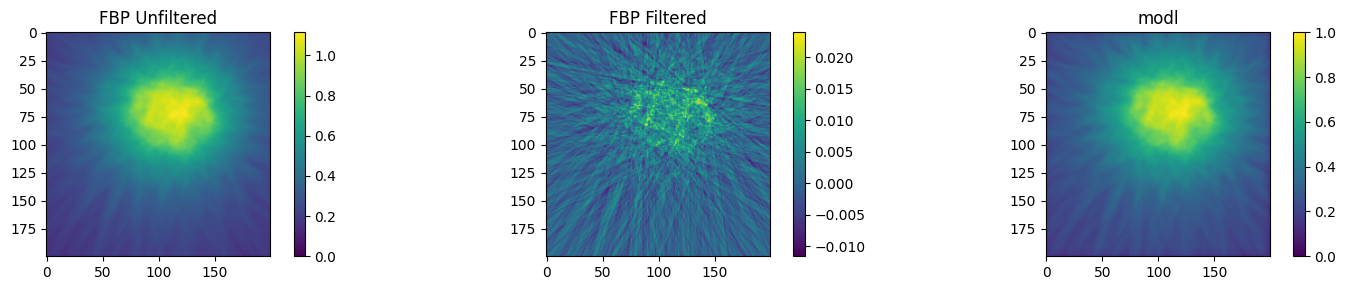

In [36]:
# Plot comparison
idx = 0
plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.imshow(opt_volume_unfilter[idx])
plt.colorbar()
plt.title("FBP Unfiltered")

plt.subplot(132)
plt.imshow(opt_volume_filter[idx])
plt.colorbar()
plt.title("FBP Filtered")


plt.subplot(133)
plt.imshow(opt_volume_modl[idx])
plt.colorbar()
plt.title("modl")

plt.tight_layout()
plt.show()